In [1]:
import pandas as pd
import matplotlib.pyplot as plt

path = "../data/sims4_dlc.xlsx"
xls = pd.ExcelFile(path)
xls.sheet_names



['Sims 4 Individual Packs', 'Sims 3 Individual Packs', 'Sims 4 Bundles']

In [2]:
df = pd.read_excel(path, sheet_name="Sims 4 Individual Packs")
df.head(3)


,Title,Release Date,Release Time,Type,Origin/ Official Price (USD),Included Actions and Gameplay,Included CAS,Included Build/Buy,Rating - Digital Spy,Rating - Gaming Trend,Rating - Amazon,Rating - Metacritic Critic,Rating - Metacritic User
0,Sims 4 (Standard Edition),2014-09-02,NaN,Base Game,39.99,NaN,NaN,NaN,NaN,75/100,4.4/5,70/100,4.1/10
1,Sims 4 Holiday Celebration,2014-12-16,NaN,Game Pack,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sims 4 Outdoor Retreat,2015-01-13,NaN,Game Pack,19.99,NaN,NaN,NaN,NaN,50/100,4.6/5,66/100,5.7/10


In [3]:
df.columns


Index(['Title', 'Release Date', 'Release Time', 'Type',
       'Origin/ Official Price (USD)', 'Included Actions and Gameplay',
       'Included CAS', 'Included Build/Buy', 'Rating - Digital Spy',
       'Rating - Gaming Trend', 'Rating - Amazon',
       'Rating - Metacritic Critic', 'Rating - Metacritic User'],
      dtype='str')

In [4]:
df.dtypes


Title                                       str
Release Date                     datetime64[us]
Release Time                                str
Type                                        str
Origin/ Official Price (USD)            float64
Included Actions and Gameplay           float64
Included CAS                                str
Included Build/Buy                          str
Rating - Digital Spy                     object
Rating - Gaming Trend                       str
Rating - Amazon                             str
Rating - Metacritic Critic                  str
Rating - Metacritic User                 object
dtype: object

In [5]:
date_like = [c for c in df.columns if "date" in c.lower() or "release" in c.lower()]
date_like


['Release Date', 'Release Time']

In [6]:
release_col = date_like[0]
df[[release_col]].head(10)


,Release Date
0,2014-09-02
1,2014-12-16
2,2015-01-13
3,2015-03-31
4,2015-05-19
5,2015-06-16
6,2015-07-14
7,2015-08-11
8,2015-09-29
9,2015-12-08


In [7]:
df["Release Date"] = pd.to_datetime(df["Release Date"], errors="coerce")
df = df.dropna(subset=["Release Date"]).copy()
df["Release Date"].min(), df["Release Date"].max(), df.shape


(Timestamp('2014-09-02 00:00:00'), Timestamp('2026-02-12 00:00:00'), (112, 13))

In [8]:
monthly = (
    df.assign(ds=df["Release Date"].dt.to_period("M").dt.to_timestamp())
      .groupby("ds")
      .size()
      .reset_index(name="y")
      .sort_values("ds")
)

monthly.head(), monthly.tail()


(          ds  y
 0 2014-09-01  1
 1 2014-12-01  1
 2 2015-01-01  1
 3 2015-03-01  1
 4 2015-05-01  1,
            ds  y
 74 2025-08-01  2
 75 2025-10-01  2
 76 2025-11-01  2
 77 2025-12-01  3
 78 2026-02-01  3)

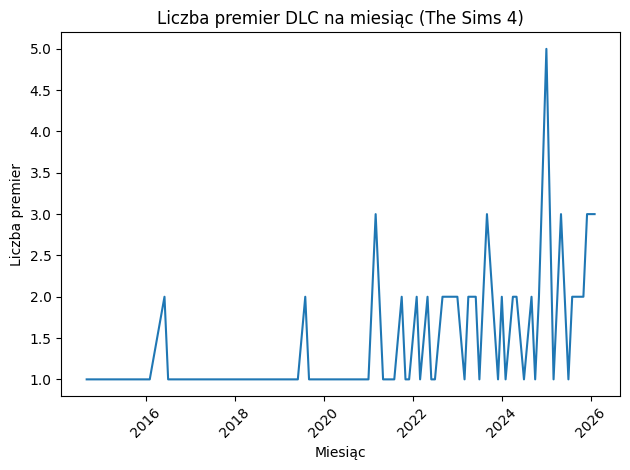

In [9]:
plt.figure()
plt.plot(monthly["ds"], monthly["y"])
plt.title("Liczba premier DLC na miesiąc (The Sims 4)")
plt.xlabel("Miesiąc")
plt.ylabel("Liczba premier")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
full_months = pd.date_range(monthly["ds"].min(), monthly["ds"].max(), freq="MS")

monthly_full = (
    monthly.set_index("ds")
           .reindex(full_months, fill_value=0)
           .rename_axis("ds")
           .reset_index()
)

monthly_full.head(), monthly_full.tail(), monthly_full["y"].value_counts().sort_index()




(          ds  y
 0 2014-09-01  1
 1 2014-10-01  0
 2 2014-11-01  0
 3 2014-12-01  1
 4 2015-01-01  1,
             ds  y
 133 2025-10-01  2
 134 2025-11-01  2
 135 2025-12-01  3
 136 2026-01-01  0
 137 2026-02-01  3,
 y
 0    59
 1    54
 2    19
 3     5
 5     1
 Name: count, dtype: int64)

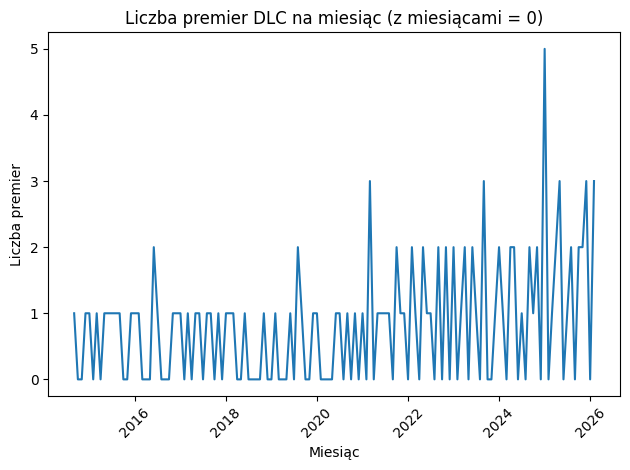

In [11]:
plt.figure()
plt.plot(monthly_full["ds"], monthly_full["y"])
plt.title("Liczba premier DLC na miesiąc (z miesiącami = 0)")
plt.xlabel("Miesiąc")
plt.ylabel("Liczba premier")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
y = monthly_full.set_index("ds")["y"]

train = y.iloc[:-12]
test = y.iloc[-12:]

train.index.min(), train.index.max(), test.index.min(), test.index.max(), len(train), len(test)



(Timestamp('2014-09-01 00:00:00'),
 Timestamp('2025-02-01 00:00:00'),
 Timestamp('2025-03-01 00:00:00'),
 Timestamp('2026-02-01 00:00:00'),
 126,
 12)

In [15]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

baseline_pred = np.repeat(train.iloc[-1], len(test))

mae_base = mean_absolute_error(test.values, baseline_pred)
mse_base = mean_squared_error(test.values, baseline_pred)
rmse_base = np.sqrt(mse_base)

mae_base, rmse_base



(1.5833333333333333, np.float64(1.9364916731037085))

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_es = ExponentialSmoothing(
    train,
    trend="add",
    seasonal=None,
    initialization_method="estimated"
)

fit_es = model_es.fit(optimized=True)
pred_es = fit_es.forecast(steps=len(test))

mae_es = mean_absolute_error(test.values, pred_es.values)
mse_es = mean_squared_error(test.values, pred_es.values)
rmse_es = np.sqrt(mse_es)

mae_es, rmse_es


/Users/ewadorotakopydlowska/Documents/zaliczenie_szeregi_sims4/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1.0555145631809837, np.float64(1.196716082306179))

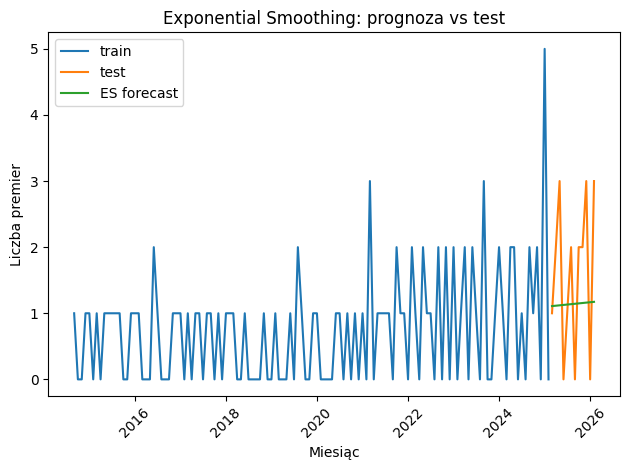

In [17]:
plt.figure()
plt.plot(train.index, train.values, label="train")
plt.plot(test.index, test.values, label="test")
plt.plot(pred_es.index, pred_es.values, label="ES forecast")
plt.title("Exponential Smoothing: prognoza vs test")
plt.xlabel("Miesiąc")
plt.ylabel("Liczba premier")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
y = y.asfreq("MS")
train = y.iloc[:-12]
test = y.iloc[-12:]


In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(
    train,
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

fit_sarima = model_sarima.fit(disp=False)
pred_sarima = fit_sarima.forecast(steps=len(test))

mae_sarima = mean_absolute_error(test.values, pred_sarima.values)
mse_sarima = mean_squared_error(test.values, pred_sarima.values)
rmse_sarima = np.sqrt(mse_sarima)

fit_sarima.aic, mae_sarima, rmse_sarima


(np.float64(308.47067909797335),
 1.0256774796981998,
 np.float64(1.1462827363285286))

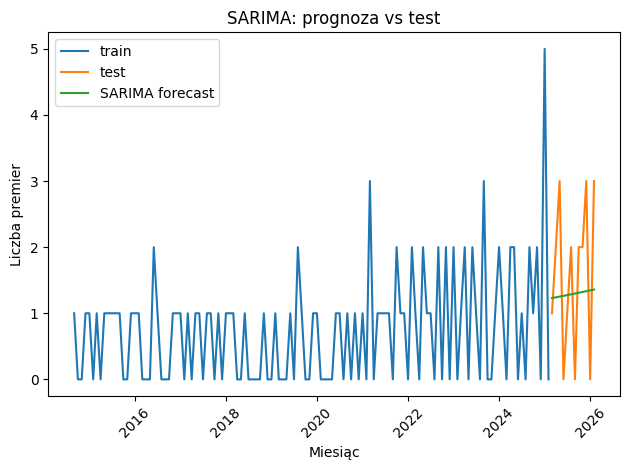

In [22]:
plt.figure()
plt.plot(train.index, train.values, label="train")
plt.plot(test.index, test.values, label="test")
plt.plot(pred_sarima.index, pred_sarima.values, label="SARIMA forecast")
plt.title("SARIMA: prognoza vs test")
plt.xlabel("Miesiąc")
plt.ylabel("Liczba premier")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



In [31]:
y_full = monthly_full.set_index("ds")["y"].asfreq("MS")

model_final = SARIMAX(
    y_full,
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

fit_final = model_final.fit(disp=False)

steps = 36
forecast_res = fit_final.get_forecast(steps=steps)
fc_mean = forecast_res.predicted_mean
fc_ci80 = forecast_res.conf_int(alpha=0.2)

fc_out = pd.DataFrame({
    "ds": fc_mean.index,
    "yhat": fc_mean.values,
    "yhat_lower": fc_ci80.iloc[:, 0].values,
    "yhat_upper": fc_ci80.iloc[:, 1].values
})


fc_out.head(), fc_out.tail()


(          ds      yhat  yhat_lower  yhat_upper
 0 2026-03-01  1.537544    0.459935    2.615153
 1 2026-04-01  1.554034    0.476279    2.631788
 2 2026-05-01  1.570700    0.492797    2.648604
 3 2026-06-01  1.587546    0.509490    2.665601
 4 2026-07-01  1.604572    0.526361    2.682782,
            ds      yhat  yhat_lower  yhat_upper
 31 2028-10-01  2.140165    1.056240    3.224090
 32 2028-11-01  2.163118    1.078912    3.247324
 33 2028-12-01  2.186317    1.101824    3.270809
 34 2029-01-01  2.209764    1.124979    3.294550
 35 2029-02-01  2.233463    1.148379    3.318548)

In [32]:
fc_out["yhat_int"] = fc_out["yhat"].round().astype(int)
fc_out["yhat_int"] = fc_out["yhat_int"].clip(lower=0)

fc_out[["ds", "yhat", "yhat_int", "yhat_lower", "yhat_upper"]].head(10)


,ds,yhat,yhat_int,yhat_lower,yhat_upper
0,2026-03-01,1.537544,2,0.459935,2.615153
1,2026-04-01,1.554034,2,0.476279,2.631788
2,2026-05-01,1.570700,2,0.492797,2.648604
3,2026-06-01,1.587546,2,0.509490,2.665601
4,2026-07-01,1.604572,2,0.526361,2.682782
5,2026-08-01,1.621780,2,0.543411,2.700150
6,2026-09-01,1.639173,2,0.560642,2.717705
7,2026-10-01,1.656753,2,0.578056,2.735450
8,2026-11-01,1.674521,2,0.595656,2.753387
9,2026-12-01,1.692480,2,0.613442,2.771519


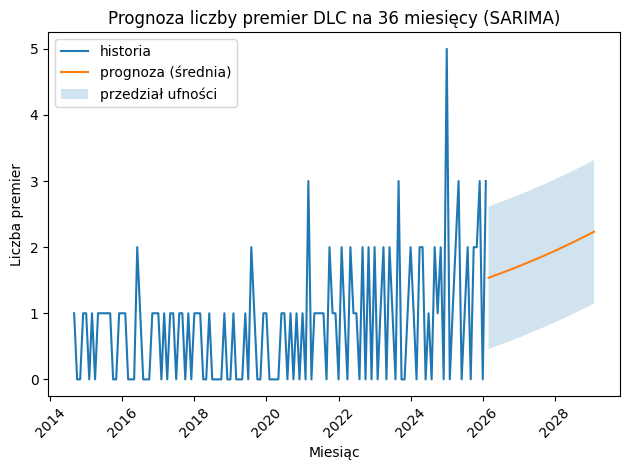

In [33]:
plt.figure()
plt.plot(y_full.index, y_full.values, label="historia")
plt.plot(fc_out["ds"], fc_out["yhat"], label="prognoza (średnia)")

plt.fill_between(
    fc_out["ds"],
    fc_out["yhat_lower"],
    fc_out["yhat_upper"],
    alpha=0.2,
    label="przedział ufności"
)

plt.title("Prognoza liczby premier DLC na 36 miesięcy (SARIMA)")
plt.xlabel("Miesiąc")
plt.ylabel("Liczba premier")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()



In [34]:
fc_out.to_csv("../data/forecast_36_months_sarima.csv", index=False)


In [39]:
import os

os.makedirs("../figures", exist_ok=True)


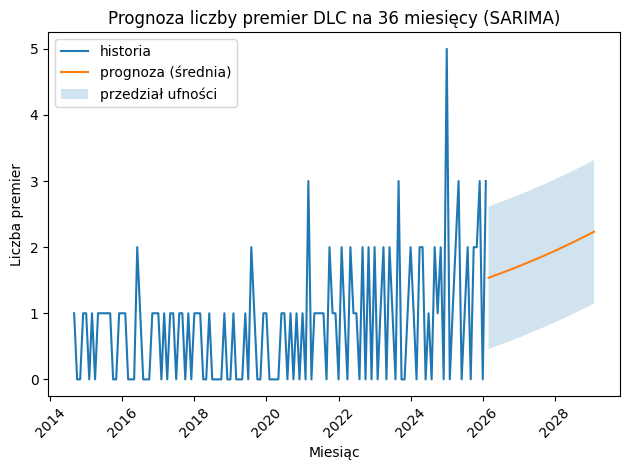

In [36]:
plt.figure()
plt.plot(y_full.index, y_full.values, label="historia")
plt.plot(fc_out["ds"], fc_out["yhat"], label="prognoza (średnia)")
plt.fill_between(fc_out["ds"], fc_out["yhat_lower"], fc_out["yhat_upper"], alpha=0.2, label="przedział ufności")
plt.title("Prognoza liczby premier DLC na 36 miesięcy (SARIMA)")
plt.xlabel("Miesiąc")
plt.ylabel("Liczba premier")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.savefig("../figures/forecast_36m_sarima.png", dpi=200, bbox_inches="tight")
plt.show()


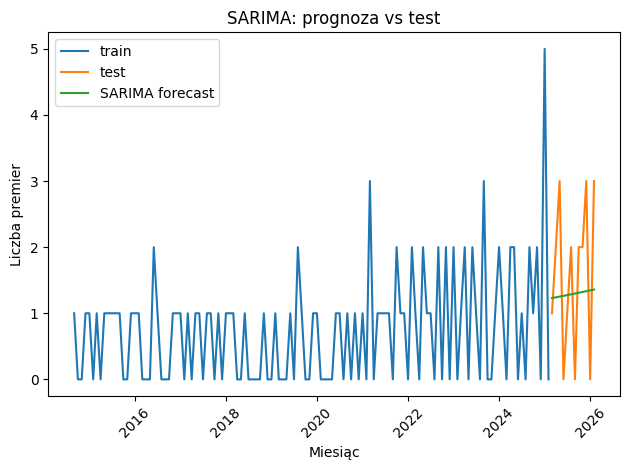

In [41]:
plt.figure()
plt.plot(train.index, train.values, label="train")
plt.plot(test.index, test.values, label="test")
plt.plot(pred_sarima.index, pred_sarima.values, label="SARIMA forecast")
plt.title("SARIMA: prognoza vs test")
plt.xlabel("Miesiąc")
plt.ylabel("Liczba premier")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.savefig("../figures/sarima_vs_test.png", dpi=200, bbox_inches="tight")
plt.show()


In [42]:
import os
sorted(os.listdir("../figures"))


['forecast_36m_sarima.png', 'sarima_vs_test.png']

In [43]:
fc_year = (
    fc_out.assign(year=fc_out["ds"].dt.year)
    .groupby("year")[["yhat", "yhat_lower", "yhat_upper"]]
    .sum()
    .reset_index()
)

fc_year


,year,yhat,yhat_lower,yhat_upper
0,2026,16.139104,5.356070,26.922138
1,2027,21.782769,8.819417,34.746121
2,2028,24.757559,11.761309,37.753809
3,2029,4.443228,2.273358,6.613097


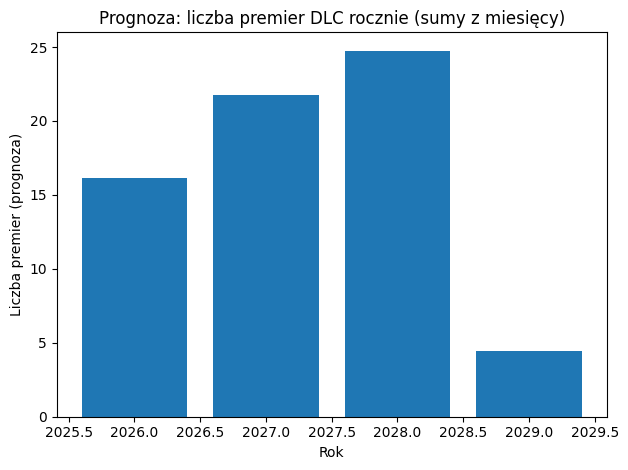

In [44]:
plt.figure()
plt.bar(fc_year["year"], fc_year["yhat"])
plt.title("Prognoza: liczba premier DLC rocznie (sumy z miesięcy)")
plt.xlabel("Rok")
plt.ylabel("Liczba premier (prognoza)")
plt.tight_layout()
plt.show()
